In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
from utils import Normalise
from dataset import ConcatSequence, HDF5Sequence
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import random
from sklearn.cluster import SpectralClustering, KMeans, MiniBatchKMeans
from utils import space_grad, space_grad_mse_loss
from resnet import ResNet
from glob import glob
import time
import h5py

In [15]:
# model = ResNet.load_from_checkpoint(glob("logs/resnet/lightning_logs/version_3/checkpoints/*.ckpt")[0])
model = ResNet.load_from_checkpoint(glob("logs/lightning_logs/version_5/checkpoints/*.ckpt")[0],
                                    root="/media/ep119/DATADRIVE3/epignatelli/deepexcite/train_dev_set/",
                                    paramset="3",
                                    batch_size=2,
                                    n_workers=0,
                                    frames_out=50)

print("Model contains {:,} parameters".format(model.parameters_count()))
filename = "/media/ep119/DATADRIVE3/epignatelli/deepexcite/train_dev_set/heartbeat_params3.hdf5"
fkset = HDF5Sequence(filename, model.frames_in, model.frames_out, model.step, transform=Normalise())

Model contains 140,305 parameters


### Network prediction

In [16]:
# get data
device = torch.device("cuda:1")
sequence = torch.as_tensor(fkset[400])

# to gpu
model = model.to(device)
sequence = sequence.to(device)

# format data
x = sequence[:model.frames_in]
y = sequence[model.frames_in:]

# infer
start = time.time()
pred = model.infer(x)
elapsed = time.time() - start
print(pred.shape)

print("Computation time: {:.6f}ms".format(elapsed))
print("Input")

# error
mae = torch.nn.functional.l1_loss(pred[:, 2], y[:, 2].cpu(), reduction="none")

torch.Size([50, 3, 256, 256])
Computation time: 1.336370ms
Input


In [17]:
# plot
rows = 25
figsize = (100,20)

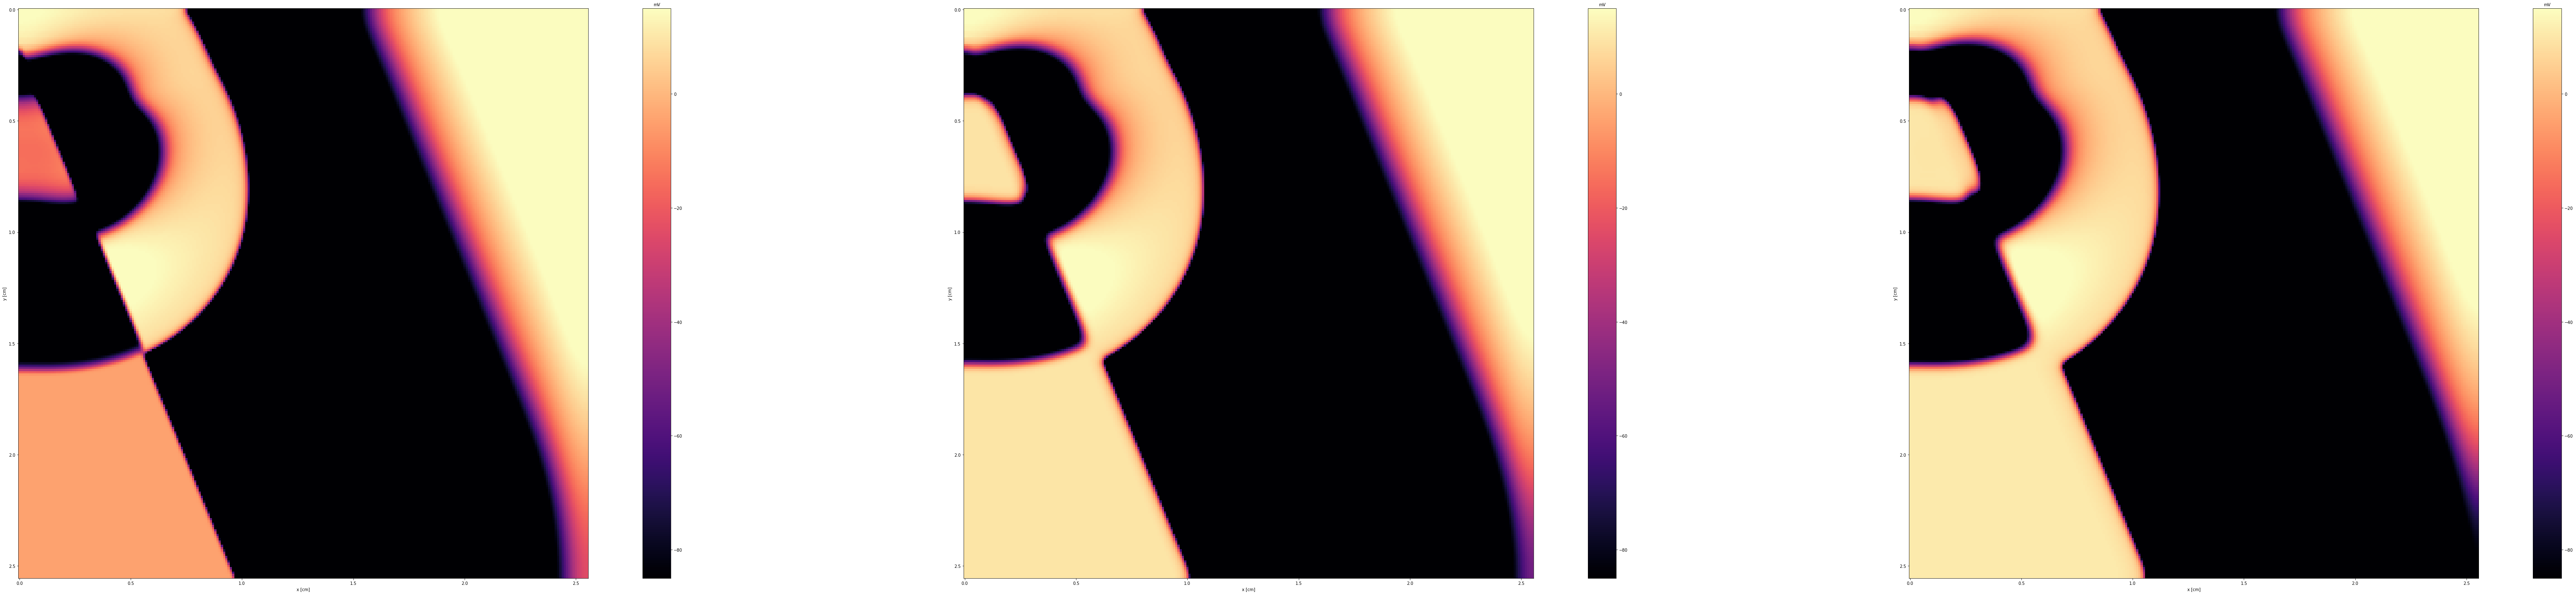

Prediction


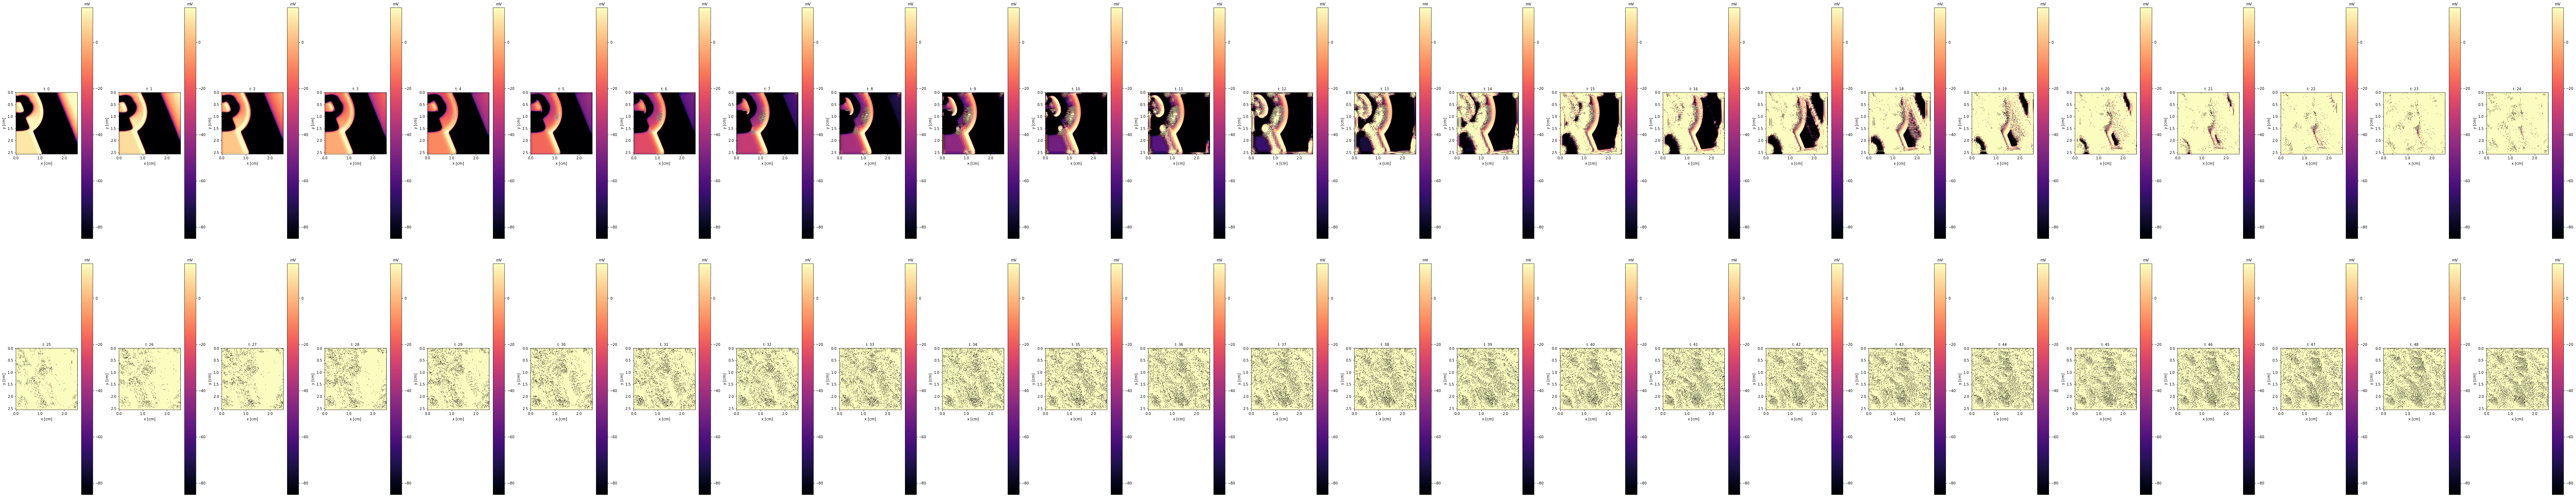

Truth


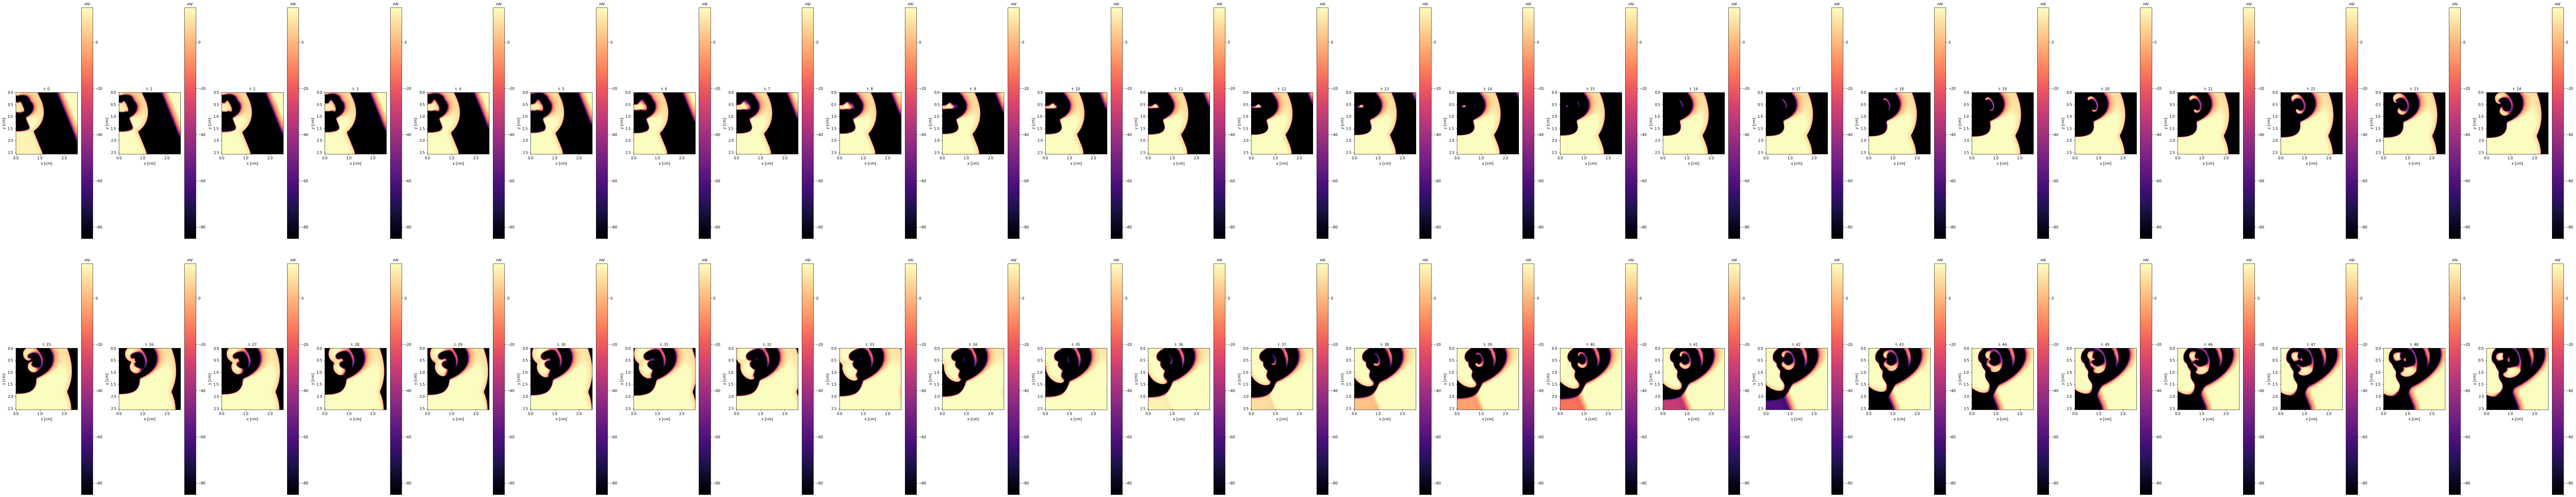

L1 loss


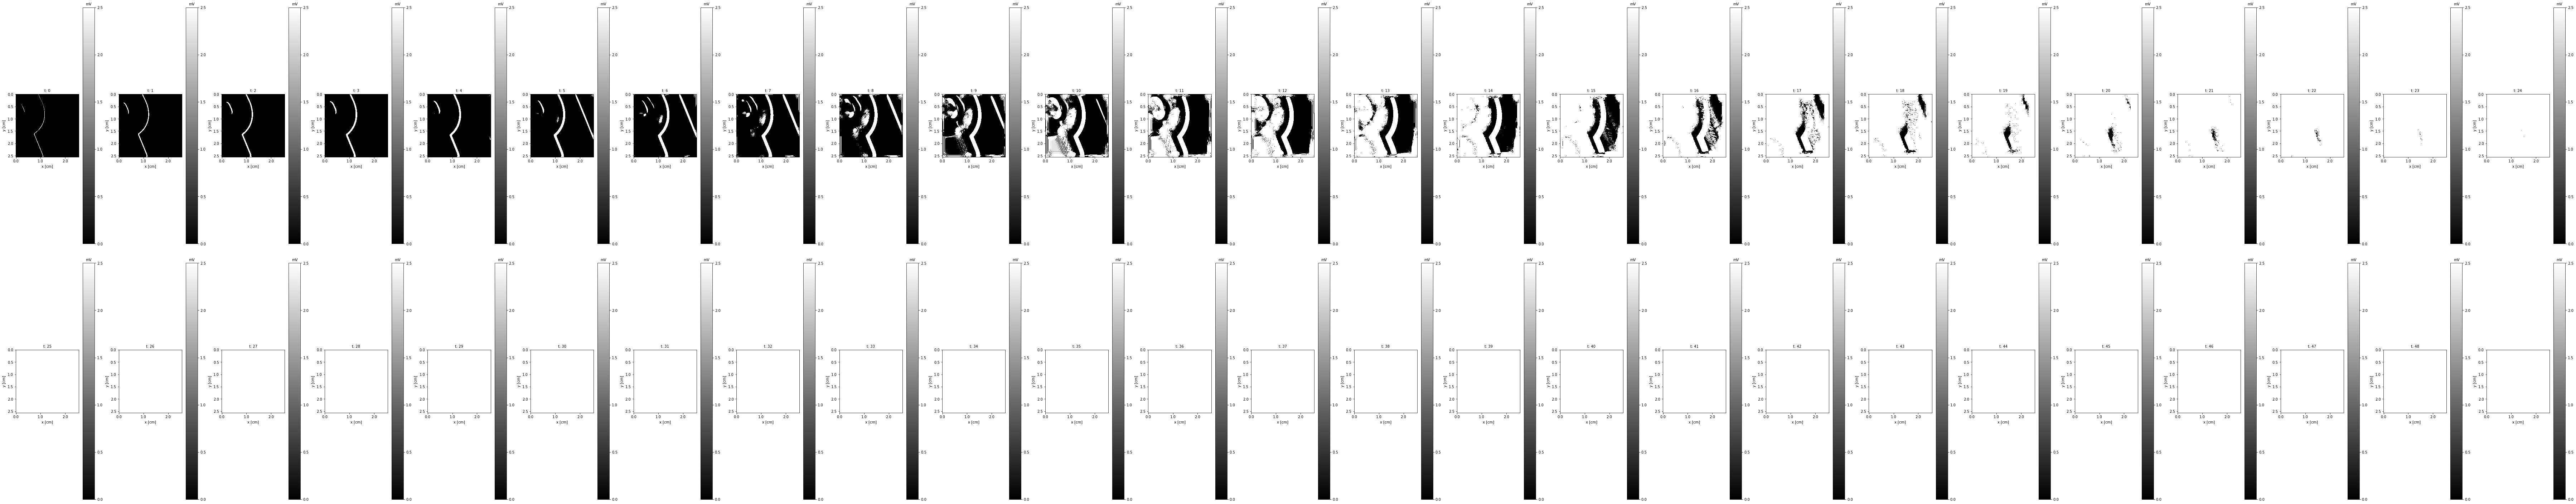

In [18]:
fig, ax = fk.plot.show_grid(fk.convert.u_to_V(x[:, 2].detach().cpu()), rows=rows, figsize=figsize)
plt.show()
print("Prediction")
fig, ax = fk.plot.show_grid(fk.convert.u_to_V(pred[:, 2].detach().cpu()), rows=rows, figsize=figsize, times=np.arange(len(y)))
plt.show()
print("Truth")
fig, ax = fk.plot.show_grid(fk.convert.u_to_V(y[:, 2].detach().cpu()), rows=rows, figsize=figsize, times=np.arange(len(y)))
plt.show()
print("L1 loss")
fig, ax = fk.plot.show_grid(fk.convert.u_to_V(mae.detach().cpu()), rows=rows, figsize=figsize, times=np.arange(len(y)), vmin=0, vmax=2.5, cmap="gray")
plt.show()

## Testing gradients

In [ ]:
dx, dy = space_grad(torch.as_tensor(value))
dxx, dxy = space_grad(torch.as_tensor(dx))
dyx, dyy = space_grad(torch.as_tensor(dy))

fig, ax = plt.subplots(3, 4, figsize=(15, 12))

ax[0, 0].set_title("dx")
im = ax[0, 0].imshow(dx, vmin=-1, vmax=1, cmap="RdBu")

ax[0, 1].set_title("dy")
im = ax[0, 1].imshow(dy, vmin=-1, vmax=1, cmap="RdBu")

ax[0, 2].set_title("dx + dy")
im = ax[0, 2].imshow(dx + dy, vmin=-1, vmax=1, cmap="RdBu")

ax[0, 3].set_title("torch.abs(dx) + torch.abs(dy)")
im = ax[0, 3].imshow(torch.abs(dx) + torch.abs(dy), vmin=-1, vmax=1, cmap="RdBu")


ax[1, 0].set_title("dxx")
im = ax[1, 0].imshow(dxx, vmin=-1, vmax=1, cmap="RdBu")

ax[1, 1].set_title("dxy")
im = ax[1, 1].imshow(dxy, vmin=-1, vmax=1, cmap="RdBu")

ax[1, 2].set_title("dxx + dxy")
im = ax[1, 2].imshow(dxx + dxy, vmin=-1, vmax=1, cmap="RdBu")

ax[1, 3].set_title("torch.abs(dxx) + torch.abs(dxy)")
im = ax[1, 3].imshow(torch.abs(dxx) + torch.abs(dxy), vmin=-1, vmax=1, cmap="RdBu")


ax[2, 0].set_title("dyx")
im = ax[2, 0].imshow(dyx, vmin=-1, vmax=1, cmap="RdBu")

ax[2, 1].set_title("dyy")
im = ax[2, 1].imshow(dyy, vmin=-1, vmax=1, cmap="RdBu")

ax[2, 2].set_title("dyx + dyy")
im = ax[2, 2].imshow(dyx + dyy, vmin=-1, vmax=1, cmap="RdBu")

ax[2, 3].set_title("torch.abs(dyx) + torch.abs(dyy)")
im = ax[2, 3].imshow(torch.abs(dyx) + torch.abs(dyy), vmin=-1, vmax=1, cmap="RdBu")

In [ ]:
a, b = pred[0, 0, 2], y[0, 0, 2]
ax, ay = space_grad(a)
bx, by = space_grad(b)
a_grad = torch.abs(ax) + torch.abs(ay)
b_grad = torch.abs(bx) + torch.abs(by)

grad = Normalise()((a_grad.detach() - b_grad.detach()).exp())
im = plt.imshow(grad, vmin=-1, vmax=1, cmap="RdBu")
plt.colorbar(im)

## Blob detection using clustering

In [ ]:
class KMeans:
    def __init__(self, n_clusters=10, n_iter=100):
        self.n_clusters = n_clusters
        self.n_iter = n_iter
        self.labels_ = None
        self.cluster_centers_ = None
        
    def fit(self, x):
        N, D = x.shape  # Number of samples, dimension of the ambient space

        c = x[:self.n_clusters, :].clone()  # Simplistic random initialization
        x_i = torch.tensor(x[:, None, :])  # (Npoints, 1, D)

        for i in range(self.n_iter):

            c_j = torch.tensor(c[None, :, :])  # (1, Nclusters, D)
            D_ij = ((x_i - c_j) ** 2).sum(-1)  # (Npoints, Nclusters) symbolic matrix of squared distances
            cl = D_ij.argmin(dim=1).long().view(-1)  # Points -> Nearest cluster

            Ncl = torch.bincount(cl)  # Class weights
            for d in range(D):  # Compute the cluster centroids with torch.bincount:
                c[:, d] = torch.bincount(cl, weights=x[:, d]) / Ncl
        self.labels_ = cl
        self.cluster_centers_ = c

In [ ]:
km = KMeans()
km.fit(torch.as_tensor(fkset[1500:1532]).flatten().view(-1, 1).cuda())
km.labels_

In [ ]:
class KMeans:
    def __init__(self, n_clusters=10, n_iter=100):
        self.n_clusters = n_clusters
        self.n_iter = n_iter
        self.labels_ = None
        self.cluster_centers_ = None
        
    def fit(self, x):
        N, D = x.shape  # Number of samples, dimension of the ambient space

        c = x[:self.n_clusters, :].clone()  # Simplistic random initialization
        x_i = torch.tensor(x[:, None, :])  # (Npoints, 1, D)

        for i in range(self.n_iter):

            c_j = torch.tensor(c[None, :, :])  # (1, Nclusters, D)
            D_ij = ((x_i - c_j) ** 2).sum(-1)  # (Npoints, Nclusters) symbolic matrix of squared distances
            cl = D_ij.argmin(dim=1).long().view(-1)  # Points -> Nearest cluster

            Ncl = torch.bincount(cl)  # Class weights
            for d in range(D):  # Compute the cluster centroids with torch.bincount:
                c[:, d] = torch.bincount(cl, weights=x[:, d]) / Ncl
        self.labels_ = cl
        self.cluster_centers_ = c

In [ ]:
km = KMeans()
km.fit(torch.as_tensor(fkset[]).flatten().view(-1, 1))
labels = cl.labels_.reshape(256, 256)

masks = np.zeros((km.n_clusters, 256, 256))
for i in range(len(value)):
    for j in range(value.shape[1]):
        masks[labels[i, j], i, j] = 1
        
fig, ax = plt.subplots(1, km.n_clusters + 1, figsize=(50, 30))
ax[0].imshow(value, cmap="gray")
for i in range(km.n_clusters):
    ax[i + 1].imshow(masks[i], cmap="gray")

In [ ]:
%%time
# reshape
points = []
for i in range(len(value)):
    for j in range(value.shape[1]):
        points.append(np.array([i, j, value[i, j]]))
points = np.array(points)

# cluster
cl = KMeans(10)
cl.fit(torch.as_tensor(value).flatten().reshape(-1, 1))

labels = cl.labels_.reshape(256, 256)
clusters = {}
masks = np.zeros((cl.n_clusters, 256, 256))
for i in range(len(value)):
    for j in range(value.shape[1]):
        masks[labels[i, j], i, j] = 1
    
fig, ax = plt.subplots(1, cl.n_clusters + 1, figsize=(50, 30))
ax[0].imshow(value, cmap="gray")
for i in range(cl.n_clusters):
    ax[i + 1].imshow(masks[i], cmap="gray")

In [ ]:
def quantize(x):
    cl = MiniBatchKMeans(10)
    cl.fit(x.flatten().reshape(-1, 1))

    labels = cl.labels_.reshape(x.shape)
    clusters = {}
    masks = np.zeros((cl.n_clusters, *x.shape))
    for i in range(len(x)):
        for j in range(x.shape[1]):
            masks[labels[i, j], i, j] = 1
    return masks, cl.cluster_centers_    
    
def quant_loss(y_hat, y):
    masks_y_hat = quantize(y_hat)
    masks_y = quantize(y)
    return nn.functional.mse_loss(y_hat, y, reduction="sum") / y_hat.size(0)

def plot_masks(masks):
    fig, ax = plt.subplots(1, len(masks), figsize=(50, 30))
    for i in range(len(masks)):
        ax[i].imshow(masks[i], cmap="gray")

In [ ]:
masks, means = quantize(value)
plot_masks(masks)

## Blob detection using MSER

In [ ]:
import cv2

vis = value.copy()
mser = cv2.MSER_create(_min_area=10, _max_area=int(1e5))
regions, points = mser.detectRegions(value.reshape(256, 256, 1).astype("uint8"))
hulls = [cv2.convexHull(p.reshape(-1, 1, 2)) for p in regions]
cv2.polylines(vis, hulls, 1, (0, 255, 255))
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(value, cmap="gray")
ax[1].imshow(vis, cmap="gray")

mask = np.zeros_like(value)
mask[regions[2]] = 0
plt.imshow(mask)

In [ ]:

        energy_loss = energy_loss * self.loss_weights.get("energy_loss",from bnaf import BNAF

In [ ]:
BNAF(512, 6, 512)

In [ ]:
from utils import time_grad, time_grad_loss

root = "/media/ep119/DATADRIVE3/epignatelli/deepexcite/train_dev_set/"
fkset = FkDataset(root, 2, 20, 5, transform=Normalise(),
                  keys=["spiral_params3.hdf5", "heartbeat_params3.hdf5", "three_points_params3.hdf5"])

sequence = fkset[1500]
t_grad = time_grad(torch.as_tensor(sequence).unsqueeze(0))
fig, ax = plt.subplots(1, len(sequence) - 1, figsize=(60, 3))
for i in range(len(sequence) - 1):
    im = ax[i].imshow(t_grad[0, i, 2], cmap="gray")
    plt.colorbar(im, ax=ax[i])

In [ ]:
fig, ax = fk.plot.show_grid(fk.convert.u_to_V(sequence[:, 2]), figsize=(20, 10))


In [ ]:
frames_in = 2
batch = torch.randn(32, 22, 3, 256, 256)
x = batch[:, :frames_in]
print(x.shape)
y = batch[:, frames_in]
print(y.shape)

In [ ]:
x = torch.randn(32, 3, 256, 256)
y = torch.randn(32, 3, 256, 256)
torch.stack([x, y], dim=1).shape


In [ ]:
a = torch.ones(1, 3, 256, 256)
b = torch.ones(1, 3, 256, 256) * 1.5
c = torch.zeros(1, 3, 256, 256)
x = torch.cat([a, b, c])
x.shape

In [14]:
list(range(10))[-2:]

[8, 9]

In [21]:
idx = 15
frames_in = 8
frames_out = 7
step = 5

a = range(100)[idx: idx + (frames_in + frames_out) * step: step]

In [22]:
sl = slice(idx, idx + (frames_in + frames_out) * step, step)
b = range(100)[sl]

In [23]:
sl.stop

90

In [11]:
a

range(15, 90, 5)

In [12]:
b

range(15, 90, 5)

In [18]:
filepath = glob("/media/ep119/DATADRIVE3/epignatelli/deepexcite/train_dev_set/*.hdf5")[0]
f = h5py.File(filepath, "r")
print(f.keys())

<KeysViewHDF5 ['duration', 'field', 'params', 'period', 'start', 'states', 'states_256', 'stimuli']>


In [15]:
f["duration"][:]

array([2, 2])

In [19]:
fk.io.load_stimuli(f)

[{'field': array([[0., 0., 0., ..., 1., 1., 1.],
         [0., 0., 0., ..., 1., 1., 1.],
         [0., 0., 0., ..., 1., 1., 1.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
  'start': 0,
  'duration': 2,
  'period': 14000},
 {'field': array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
  'start': 26000,
  'duration': 2,
  'period': 20000}]

In [131]:
s = HDF5Sequence(filepath, 3, 5, 5, clean_from_stimuli=True)

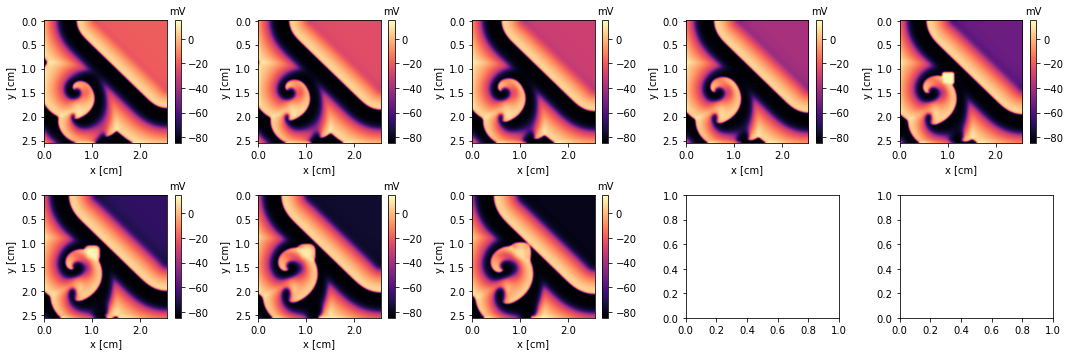

In [133]:
a = fk.plot.show_grid(fk.convert.u_to_V(random.choice(s)[:, 2]), figsize=(15, 5))

In [112]:
s.filename

'/media/ep119/DATADRIVE3/epignatelli/deepexcite/train_dev_set/heartbeat_params8.hdf5'

In [1]:
f.close()

NameError: name 'f' is not defined

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pytorch_lightning as pl
from realnvp import RealNVP
from glob import glob
from sklearn import datasets

In [16]:
!ls -l logs/realnvp/lightning_logs

total 164
drwxrwxr-x 3 ep119 ep119 4096 Sep 20 16:34 version_0
drwxrwxr-x 3 ep119 ep119 4096 Sep 20 17:50 version_1
drwxrwxr-x 3 ep119 ep119 4096 Sep 20 18:19 version_10
drwxrwxr-x 3 ep119 ep119 4096 Sep 20 18:19 version_11
drwxrwxr-x 3 ep119 ep119 4096 Sep 20 18:20 version_12
drwxrwxr-x 3 ep119 ep119 4096 Sep 20 21:44 version_13
drwxrwxr-x 3 ep119 ep119 4096 Sep 20 21:52 version_14
drwxrwxr-x 3 ep119 ep119 4096 Sep 20 22:03 version_15
drwxrwxr-x 3 ep119 ep119 4096 Sep 20 22:03 version_16
drwxrwxr-x 3 ep119 ep119 4096 Sep 20 22:16 version_17
drwxrwxr-x 3 ep119 ep119 4096 Sep 20 22:17 version_18
drwxrwxr-x 3 ep119 ep119 4096 Sep 20 22:19 version_19
drwxrwxr-x 3 ep119 ep119 4096 Sep 20 17:52 version_2
drwxrwxr-x 3 ep119 ep119 4096 Sep 20 22:21 version_20
drwxrwxr-x 3 ep119 ep119 4096 Sep 20 22:22 version_21
drwxrwxr-x 3 ep119 ep119 4096 Sep 20 22:24 version_22
drwxrwxr-x 3 ep119 ep119 4096 Sep 20 22:25 version_23
drwxrwxr-x 3 ep119 ep119 4096 Sep 20 22:25 version_24
drwxrwxr-x 3 ep119 ep

In [17]:
model = RealNVP.load_from_checkpoint(glob("logs/realnvp/lightning_logs/version_40/checkpoints/*.ckpt")[0]).cuda()

In [18]:
samples = model.sample(2000).detach().cpu()
moons = datasets.make_moons(2000, noise=0.1)[0]

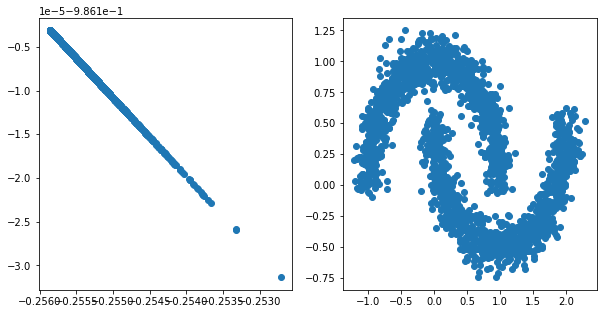

In [21]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(samples[:, 0], samples[:, 1])
ax[1].scatter(moons[:, 0], moons[:, 1])

In [22]:
[model.transformations[i].mask for i in range(len(model.transformations))]

[tensor([1, 0], device='cuda:0'),
 tensor([0, 1], device='cuda:0'),
 tensor([1, 0], device='cuda:0'),
 tensor([0, 1], device='cuda:0'),
 tensor([1, 0], device='cuda:0')]

In [14]:
import torch
a = torch.arange(10) % 2
a

tensor([0, 1, 0, 1, 0, 1, 0, 1, 0, 1])

In [15]:
torch.roll(a, -1)

tensor([1, 0, 1, 0, 1, 0, 1, 0, 1, 0])

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from deepreact import DeepReact
from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import LearningRateLogger, ModelCheckpoint
from pytorch_lightning.callbacks.base import Callback

In [9]:
n_diffusion_layers = 5
n_diffusion_filters = 5
diffusion_kernel_size = (1, 5, 5)
n_reaction_components = 5
n_reaction_layers = 5
n_reaction_filters = 5
reaction_kernel_size = (1, 5, 5)
frames_in = 5
frames_out = 5
model = DeepReact(
    n_diffusion_layers,
    n_diffusion_filters,
    diffusion_kernel_size,
    n_reaction_components,
    n_reaction_layers,
    n_reaction_filters,
    reaction_kernel_size,
    frames_in,
    frames_out,
    1, "", "", "", 32, 3).cuda()

In [13]:
u = torch.randn(model.hparams.batch_size, model.hparams.frames_in, 1, 256, 256).cuda()

In [14]:
solve = model.solve(u).shape

In [16]:
batch = torch.randn(model.hparams.batch_size, model.hparams.frames_in + model.hparams.frames_in, 5, 256, 256).cuda()

In [17]:
forward = model(u)

RuntimeError: start (5) + length (5) exceeds dimension size (5).

## WASSERSTEIN DISTANCE

In [33]:
from scipy.stats import wasserstein_distance

In [54]:
a = np.random.normal(size=128)
b = np.random.normal(size=128)

In [55]:
wasserstein_distance(a, b)

0.11216493408892086

In [58]:
d = []
for i in range(2000):
    d.append(wasserstein_distance(np.random.normal(size=128), np.random.normal(size=128)))

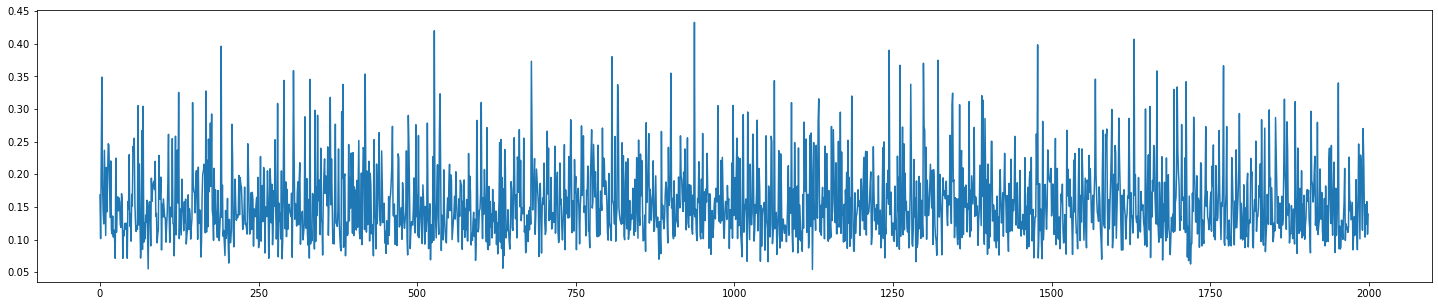

In [63]:
plt.figure(figsize=(25, 5))
plt.plot(d)

In [70]:
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt
import random

In [71]:
filename = "/media/ep119/DATADRIVE3/epignatelli/deepexcite/train_dev_set/heartbeat_params3.hdf5"
fkset = HDF5Sequence(filename, 2, 2, 10)

(4, 1200, 1200)


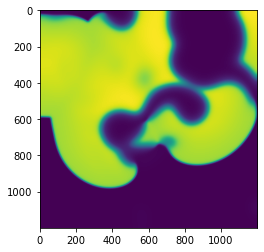

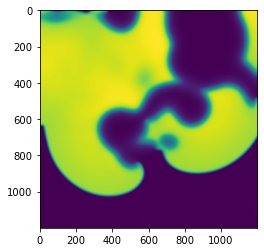

In [89]:
idx = random.randint(0, len(fkset))
x = np.array([x[2] for x in fkset[idx:idx + 2]])
print(x.shape)
plt.imshow(x[0])
plt.show()
plt.imshow(x[1])

In [93]:
def wasserstein(a, b):
    a = a.flatten()
    b = b.flatten()
    return wasserstein_distance(a, b)

def mse(a, b):
    return np.sqrt(a ** 2 + b ** 2).mean()

In [91]:
wasserstein(x[0], x[1])

0.03007460998373417

In [94]:
mse(a, b)

1.2594885776355957

In [95]:
def compare():
    idx = random.randint(0, len(fkset))
    x = np.array([x[2] for x in fkset[idx:idx + 2]])
    print(x.shape)
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].imshow(x[0])
    ax[1].imshow(x[1])
    
    w = wasserstein(x[0], x[1])
    m = mse(x[0], x[1])
    return w, m

(4, 1200, 1200)
(4, 1200, 1200)
(4, 1200, 1200)
(4, 1200, 1200)
(4, 1200, 1200)
(4, 1200, 1200)
(4, 1200, 1200)
(4, 1200, 1200)
(4, 1200, 1200)
(4, 1200, 1200)


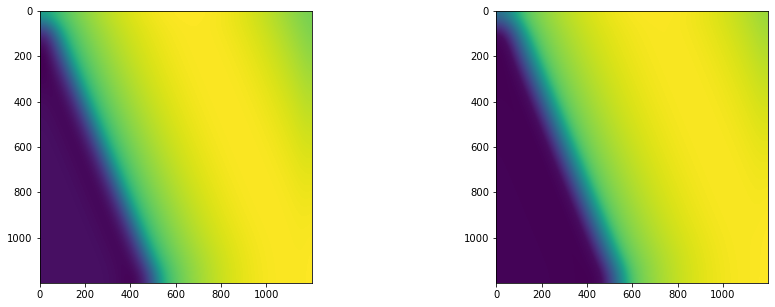

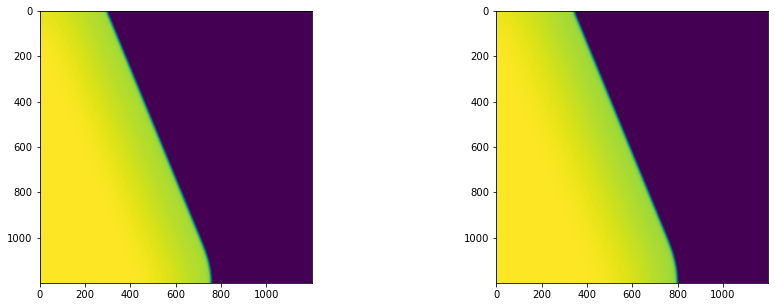

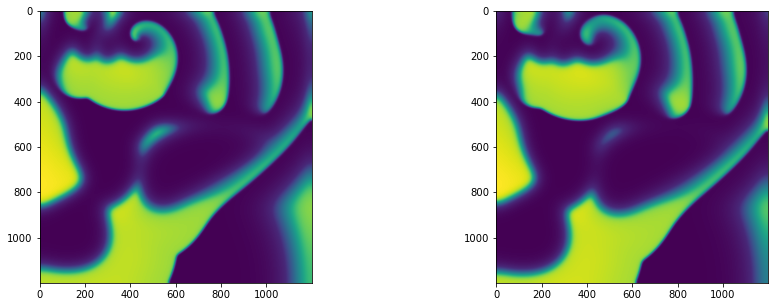

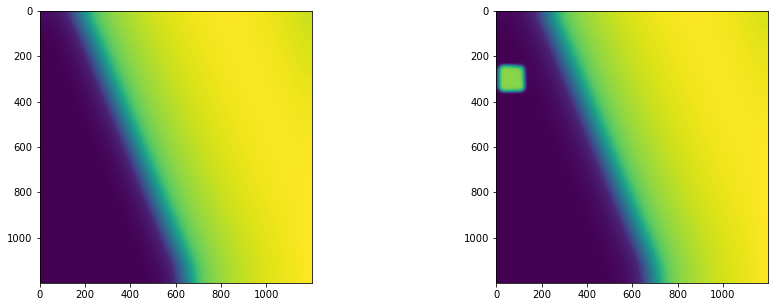

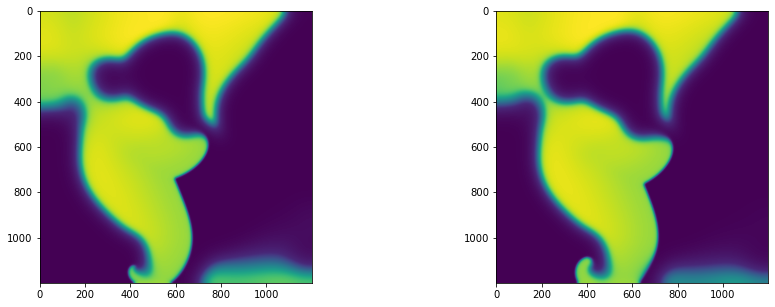

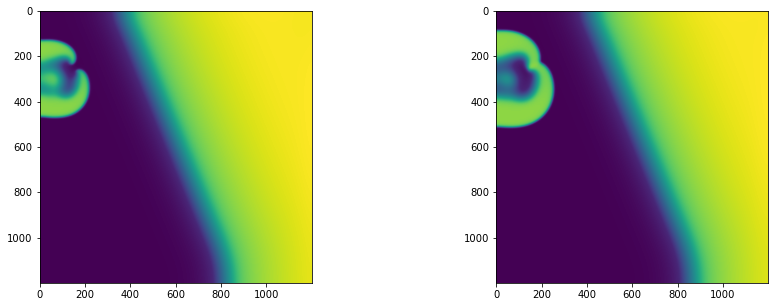

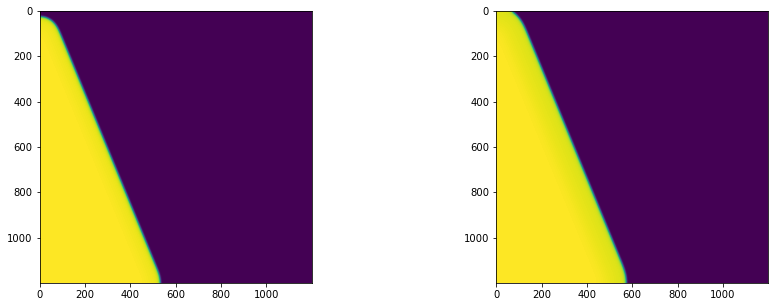

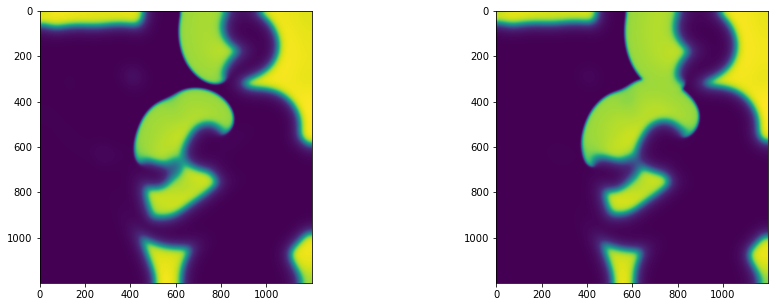

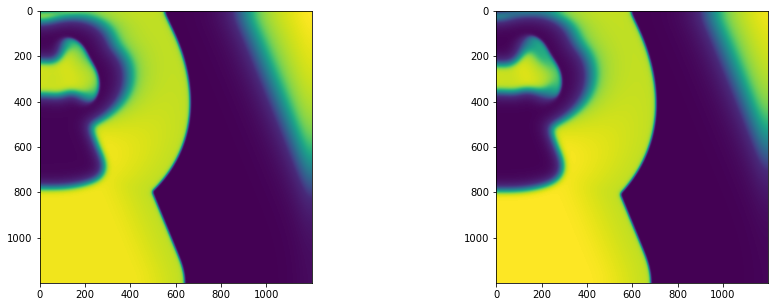

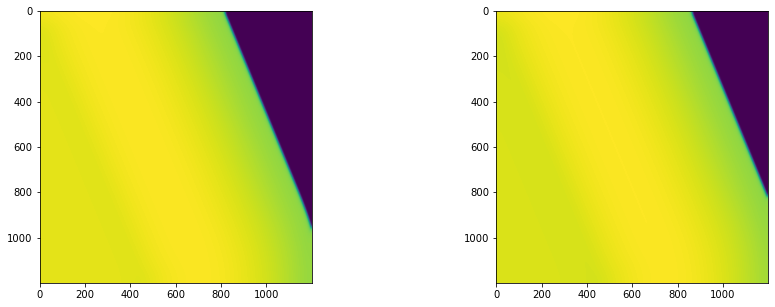

In [99]:
ws, ms = [], []
for i in range(10):
    w, m = compare()
    ws.append(w)
    ms.append(m)

In [100]:
ws

[0.0815050039959658,
 0.04937189893949984,
 0.008141837006033027,
 0.03968377534324991,
 0.01811178076074536,
 0.033740607841255266,
 0.047486453133515,
 0.004306468583721396,
 0.007434302503692475,
 0.038361295831857684]

In [101]:
def torch_cdf_loss(tensor_a,tensor_b,p=1):
    # last-dimension is weight distribution
    # p is the norm of the distance, p=1 --> First Wasserstein Distance
    # to get a positive weight with our normalized distribution
    # we recommend combining this loss with other difference-based losses like L1

    # normalize distribution, add 1e-14 to divisor to avoid 0/0
    tensor_a = tensor_a / (torch.sum(tensor_a, dim=-1, keepdim=True) + 1e-14)
    tensor_b = tensor_b / (torch.sum(tensor_b, dim=-1, keepdim=True) + 1e-14)
    # make cdf with cumsum
    cdf_tensor_a = torch.cumsum(tensor_a,dim=-1)
    cdf_tensor_b = torch.cumsum(tensor_b,dim=-1)

    # choose different formulas for different norm situations
    if p == 1:
        cdf_distance = torch.sum(torch.abs((cdf_tensor_a-cdf_tensor_b)),dim=-1)
    elif p == 2:
        cdf_distance = torch.sqrt(torch.sum(torch.pow((cdf_tensor_a-cdf_tensor_b),2),dim=-1))
    else:
        cdf_distance = torch.pow(torch.sum(torch.pow(torch.abs(cdf_tensor_a-cdf_tensor_b),p),dim=-1),1/p)

    cdf_loss = cdf_distance.mean()
    return cdf_loss

In [102]:
wasserstein(x[0], x[1])

0.03007460998373417

In [104]:
torch_cdf_loss(torch.as_tensor(x[0]), torch.as_tensor(x[1]))

tensor(59.0558)

In [106]:
ws

[0.0815050039959658,
 0.04937189893949984,
 0.008141837006033027,
 0.03968377534324991,
 0.01811178076074536,
 0.033740607841255266,
 0.047486453133515,
 0.004306468583721396,
 0.007434302503692475,
 0.038361295831857684]

In [107]:
ms

[1.2712119,
 0.7398456,
 0.5152489,
 1.005227,
 0.61535496,
 0.79236406,
 0.39596283,
 0.3907923,
 0.68090177,
 1.4270579]

In [111]:
[x[0] - x[1] for x in zip(ws, ms)]

[-1.1897068585681212,
 -0.6904736749626302,
 -0.5071070576854343,
 -0.9655431943756831,
 -0.5972431744356352,
 -0.7586234530374985,
 -0.3484763812247003,
 -0.3864858416541631,
 -0.6734674633196718,
 -1.3886965664499415]

In [115]:
import torch
torch.nn.functional.pad(torch.ones(10), pad=(-1, -1), mode="constant", value=0.)

tensor([1., 1., 1., 1., 1., 1., 1., 1.])

In [127]:
u = torch.randn(32, 1, 3, 256, 256)
D = torch.nn.functional.pad(torch.ones_like(u), pad=(-5, -5, -5, -5), mode="constant", value=0.)
D = torch.nn.functional.pad(D, pad=(5, 5, 5, 5), mode="constant", value=0.)

In [128]:
D.shape

torch.Size([32, 1, 3, 256, 256])

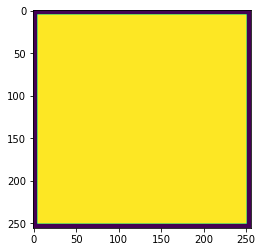

In [129]:
plt.imshow(D[0, 0, 0])

In [1]:
from glob import glob
import re
import os
root = r'/media/ep119/DATADRIVE3/epignatelli/deepexcite/train_dev_set/'
regex = '^spiral.*_PARAMS5.hdf5'

In [2]:
%load_ext autoreload
%autoreload 2

In [7]:
from dataset import ConcatSequence, DataStream, imresize
import fenton_karma as fk
import matplotlib.pyplot as plt
import random
import torch
from functools import partial
import matplotlib
matplotlib.use("Qt4Agg")

/home/ep119/.conda/envs/fk/lib/python3.8/importlib/__init__.py:127: MatplotlibDeprecationWarning: 
The matplotlib.backends.backend_qt4agg backend was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  return _bootstrap._gcd_import(name[level:], package, level)


In [8]:
data = ConcatSequence(root, 2, 1, 5, regex, partial(imresize, size=(128, 128), method="bilinear"), False)

In [9]:
sample = data[1000]
state = fk.model.State(*sample[0])
fk.plot.plot_state(state)
plt.show()

In [11]:
from typing import NamedTuple

class State(NamedTuple):
    v: str
    w: int
    u: int
    l: int = None
    j: int = None



In [12]:
tuple(filter(None, State(2, 3, 5)))

(2, 3, 5)

In [1]:
import jax
import jax.numpy as jnp
import pickle
import matplotlib.pyplot as plt
from resnet_jax import ResNet
import matplotlib
import warnings
warnings.filterwarnings("ignore")
from jax.tree_util import tree_flatten, tree_unflatten
from operator import sub

In [2]:
def normalise(leaves):
    minima = [x.min() for x in leaves]
    maxima = [x.max() for x in leaves]
    m = min(minima)
    M = max(maxima)
    print(m, M)
    return [(l - m) / (M - m) for l in leaves]

def plot_kernel(kernel):
    inp, d, w, h, out = kernel.shape
    fig, axes = plt.subplots(inp, out, figsize=(out * 2, inp * 2))
    if 1 in axes.shape:
        ax = [ax]
    
    for i in range(inp):
        for j in range(out):
            im = axes[i][j].imshow(kernel[i, ..., j])
            plt.colorbar(im, ax=axes[i][j])
    plt.show()
    return fig, axes
            
def plot_bias(bias):
    return plt.plot(bias.squeeze())
    
def plot_params(filepath):
    with open(filepath, "rb") as f:
        params = pickle.load(f)    
    leaves, indices = tree_flatten(params)
    print([x.shape for x in leaves])
    leaves = normalise(leaves)
    for i in range(0, len(leaves), 2):
        plot_kernel(leaves[i])
        plot_bias(leaves[i + 1])

def plot_diff_params(filepath_a, filepath_b):
    with open(filepath_a, "rb") as f:
        params_a = pickle.load(f)
    with open(filepath_b, "rb") as f:
        params_b = pickle.load(f)
    
    leaves_a, _ = tree_flatten(params_a)
    leaves_b, _ = tree_flatten(params_b)
    leaves = [abs(leaves_b[i] - leaves_a[i]) for i in range(len(leaves_a))]
    print([x.shape for x in leaves])
    for i in range(0, len(leaves), 2):
        plot_kernel(leaves[i])
        plot_bias(leaves[i + 1])    
    
        
def compare_kernels(kernels_a, kernels_b):
    assert kernels_a.shape == kernels_b.shape
    inp, d, w, h, out = kernels_a.shape
    fig, axes = plt.subplots(inp, out * 2 + 1, figsize=(out * 4, inp * 2))
    print(axes.shape)
    for i in range(inp):
        for j in range(out):
            im = axes[i, j].imshow(kernels_a[i, ..., j], vmin=0, vmax=1)
            plt.colorbar(im, ax=axes[i, j])
            im = axes[i, j + out + 1].imshow(kernels_b[i, ..., j], vmin=0, vmax=1)
            plt.colorbar(im, ax=axes[i, j + out + 1])
    
def compare_params(filepath_a, filepath_b):
    with open(filepath_a, "rb") as f:
        params_a = pickle.load(f)
    with open(filepath_b, "rb") as f:
        params_b = pickle.load(f)        
        
    leaves_a, _ = tree_flatten(params_a)
    leaves_b, _ = tree_flatten(params_b)
    print([x.shape for x in leaves_a])
    leaves_a = normalise(leaves_a)
    leaves_b = normalise(leaves_b)
    
    for i in range(0, len(leaves_a), 2):
        compare_kernels(leaves_a[i], leaves_b[i])
        plt.show()
        print("---")

[(2, 3, 3, 3, 8), (1, 8, 1, 1, 1), (8, 3, 3, 3, 8), (1, 8, 1, 1, 1), (8, 3, 3, 3, 8), (1, 8, 1, 1, 1), (8, 3, 3, 3, 8), (1, 8, 1, 1, 1), (8, 3, 3, 3, 8), (1, 8, 1, 1, 1), (8, 3, 3, 3, 8), (1, 8, 1, 1, 1), (8, 3, 3, 3, 8), (1, 8, 1, 1, 1), (8, 3, 3, 3, 8), (1, 8, 1, 1, 1), (8, 3, 3, 3, 8), (1, 8, 1, 1, 1), (8, 3, 3, 3, 8), (1, 8, 1, 1, 1), (8, 3, 3, 3, 8), (1, 8, 1, 1, 1), (8, 3, 3, 3, 1), (1, 1, 1, 1, 1)]


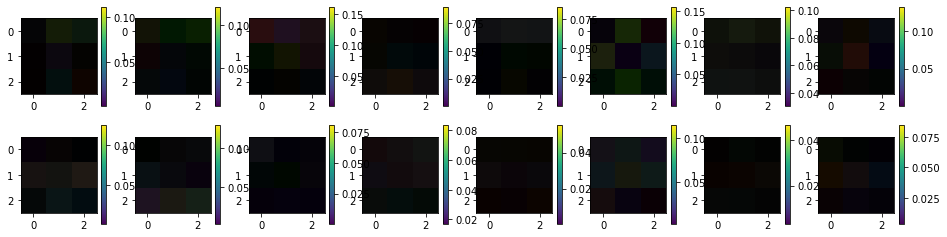

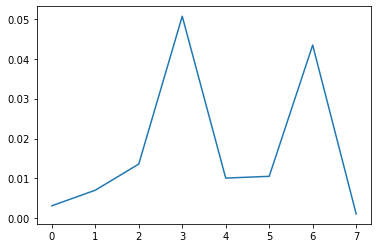

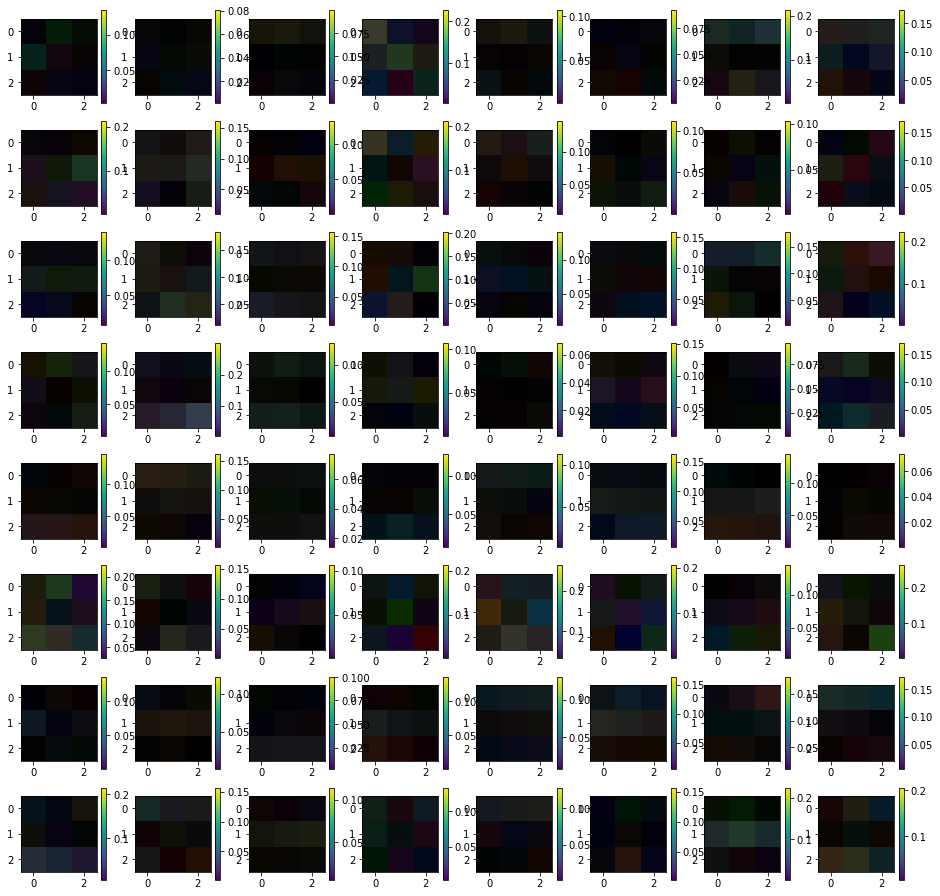

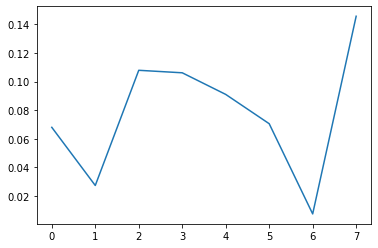

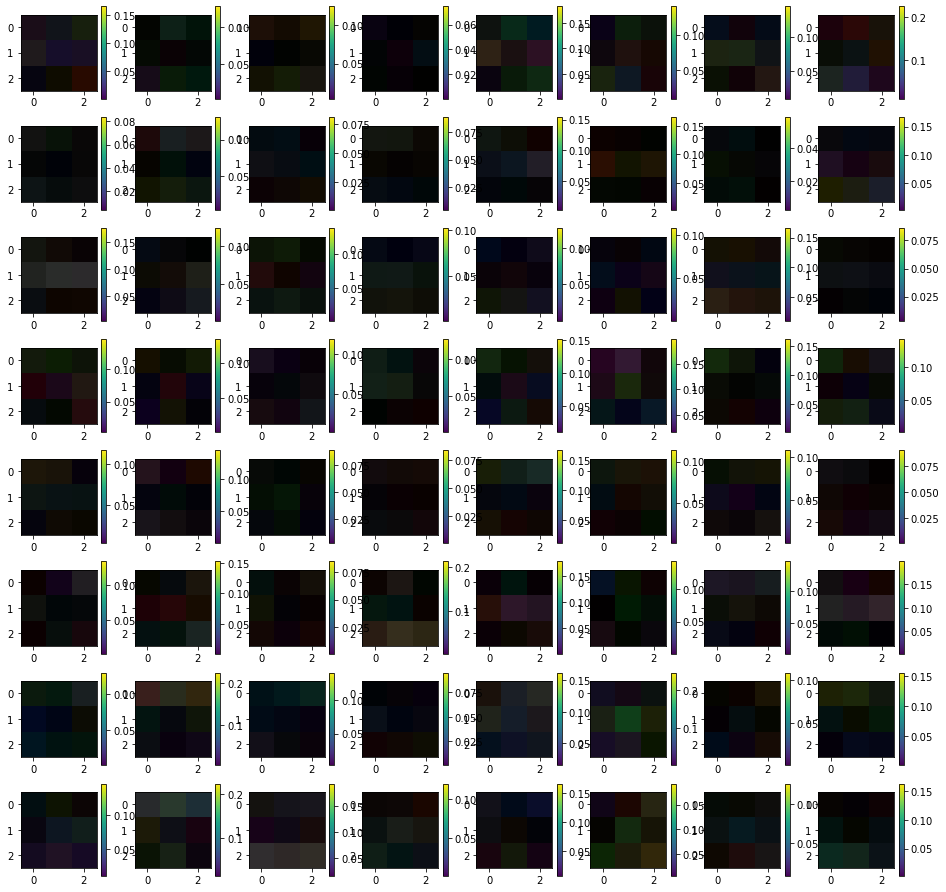

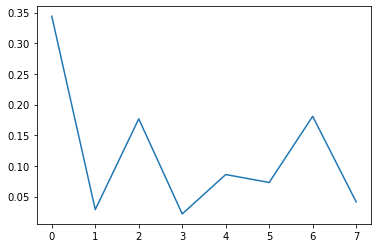

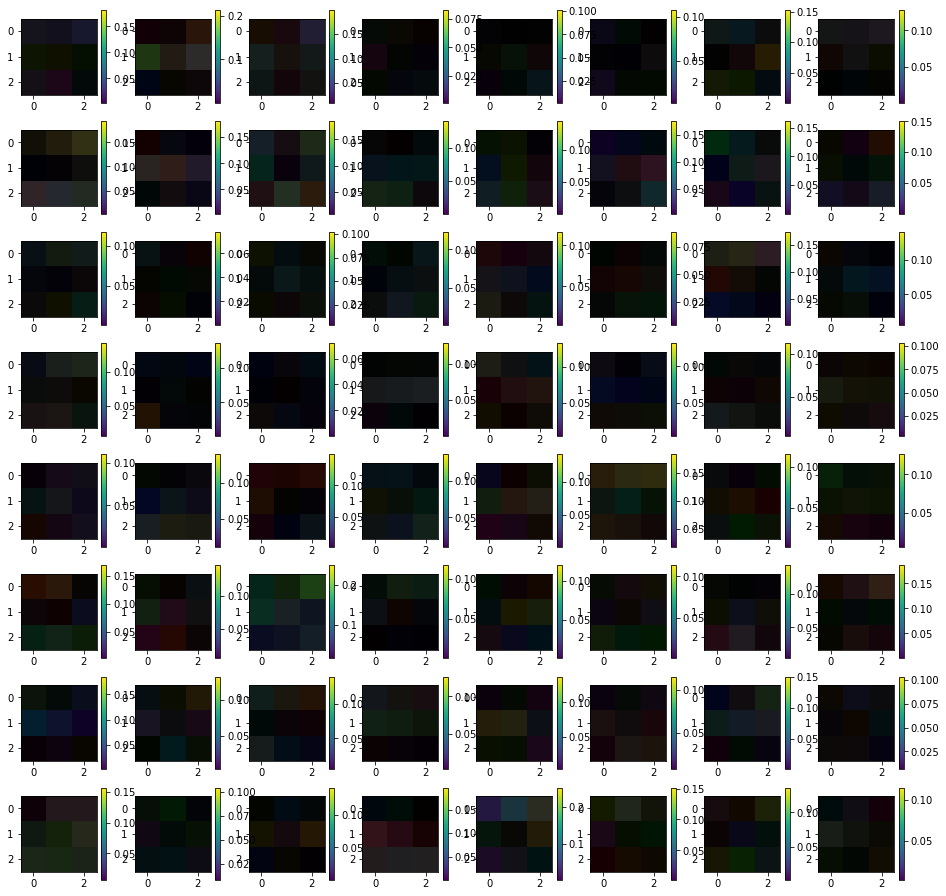

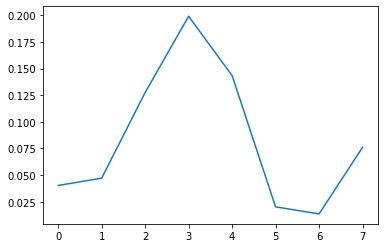

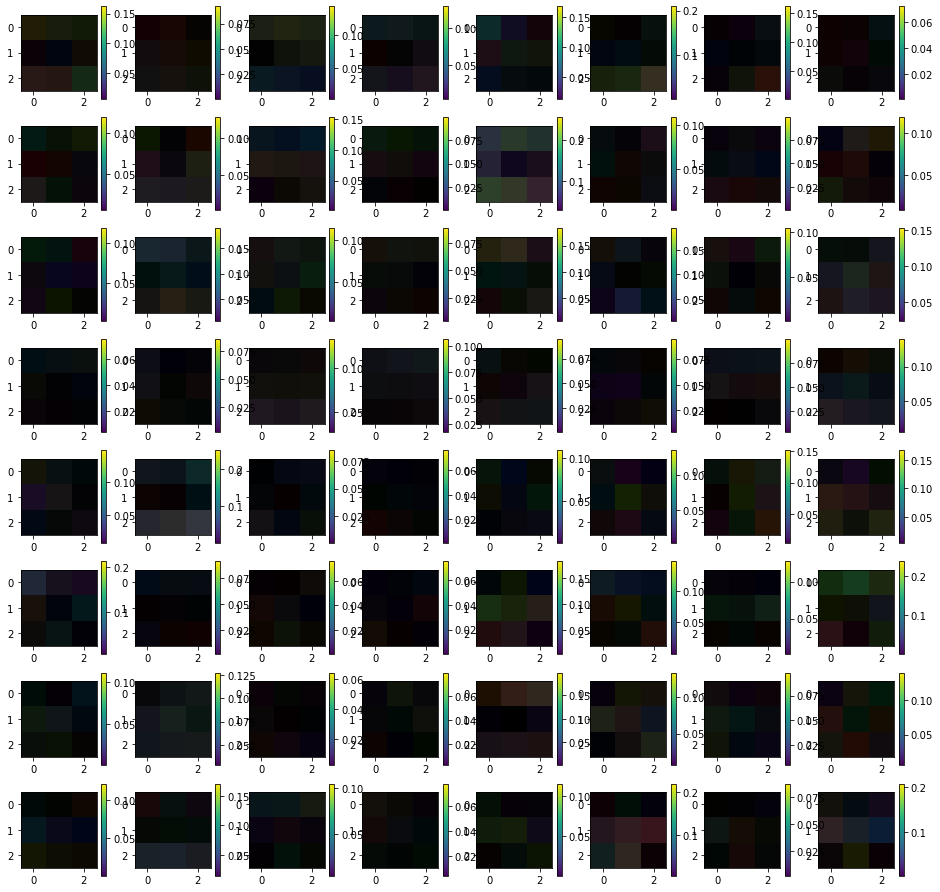

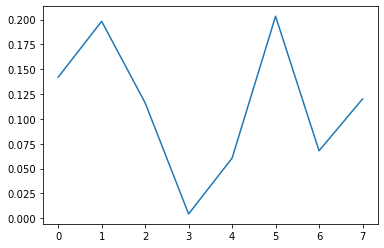

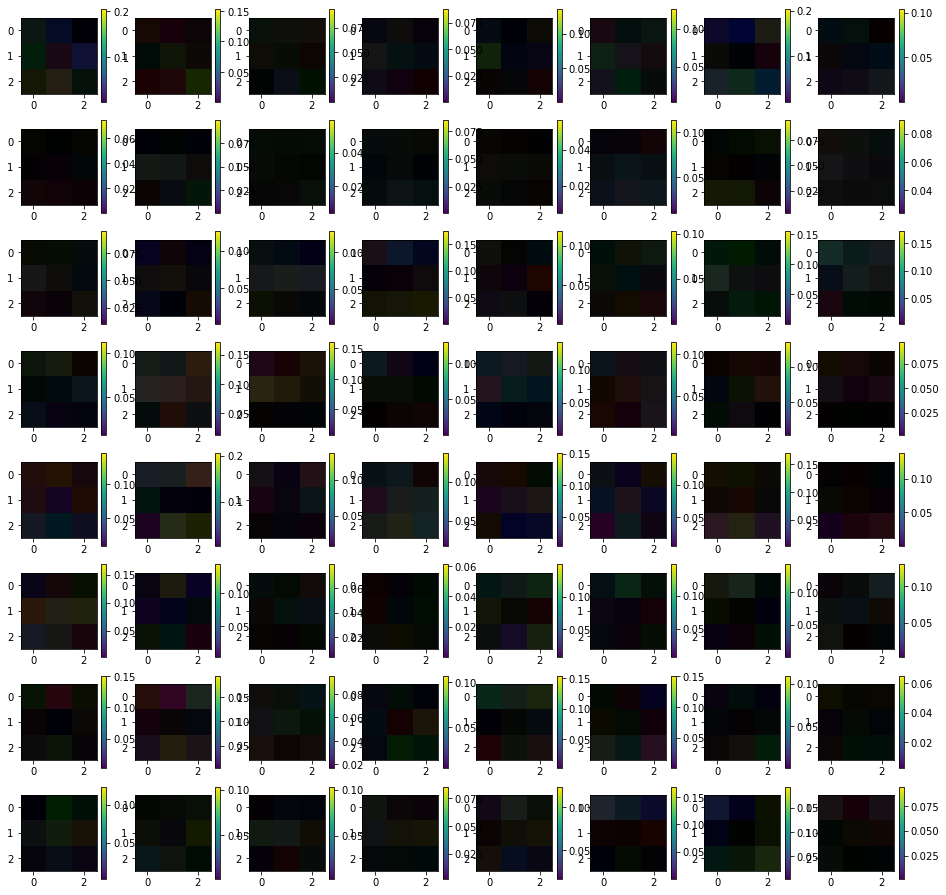

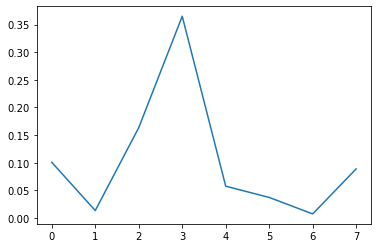

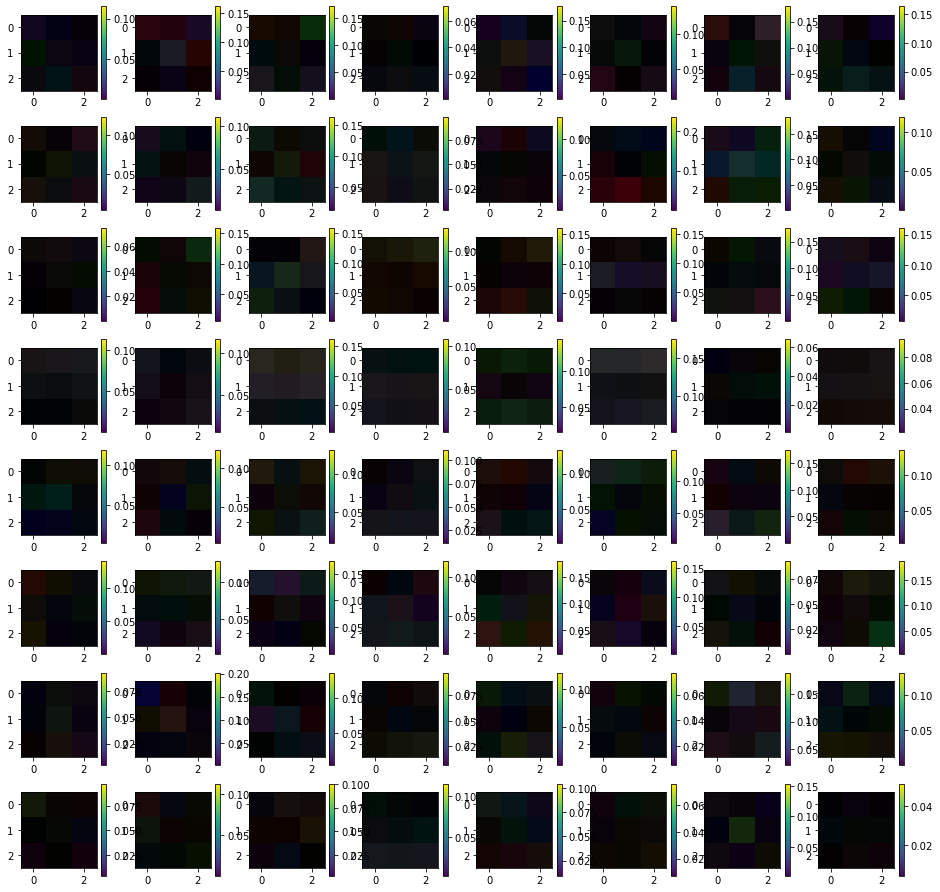

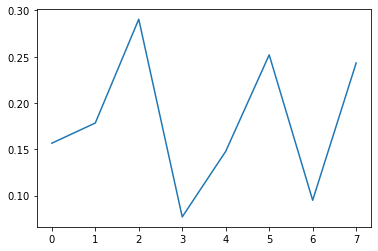

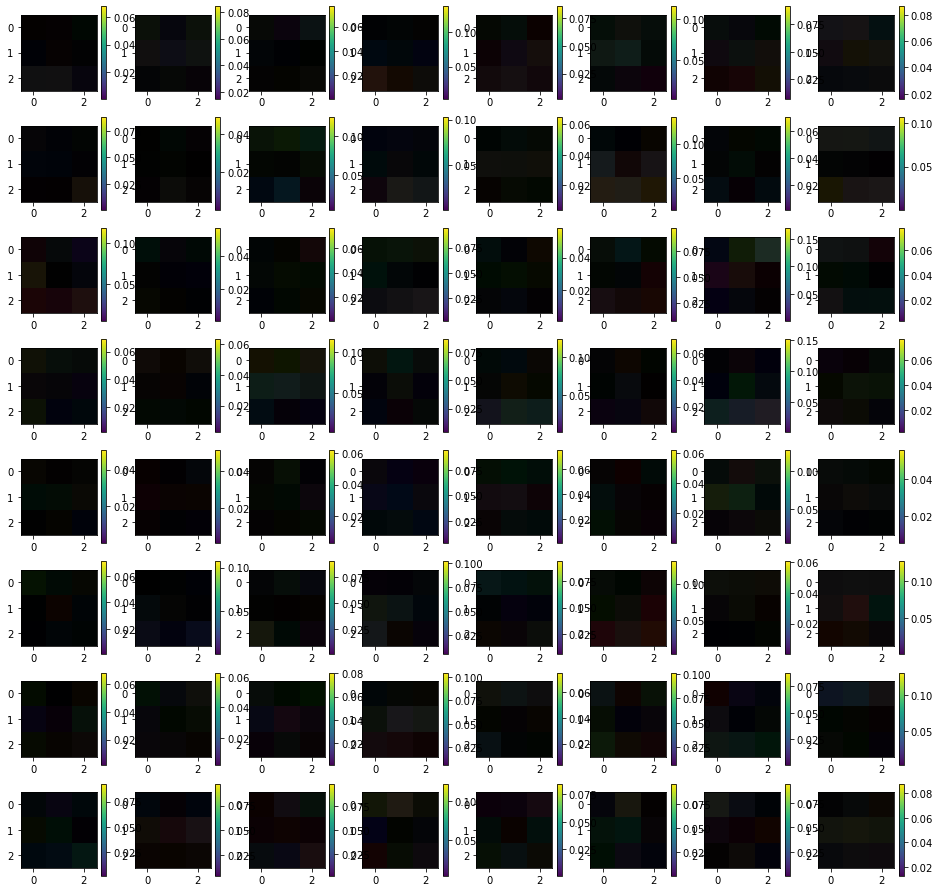

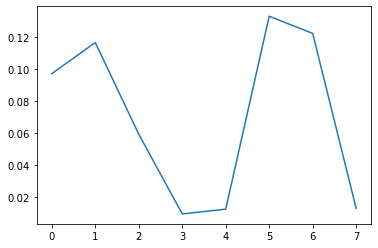

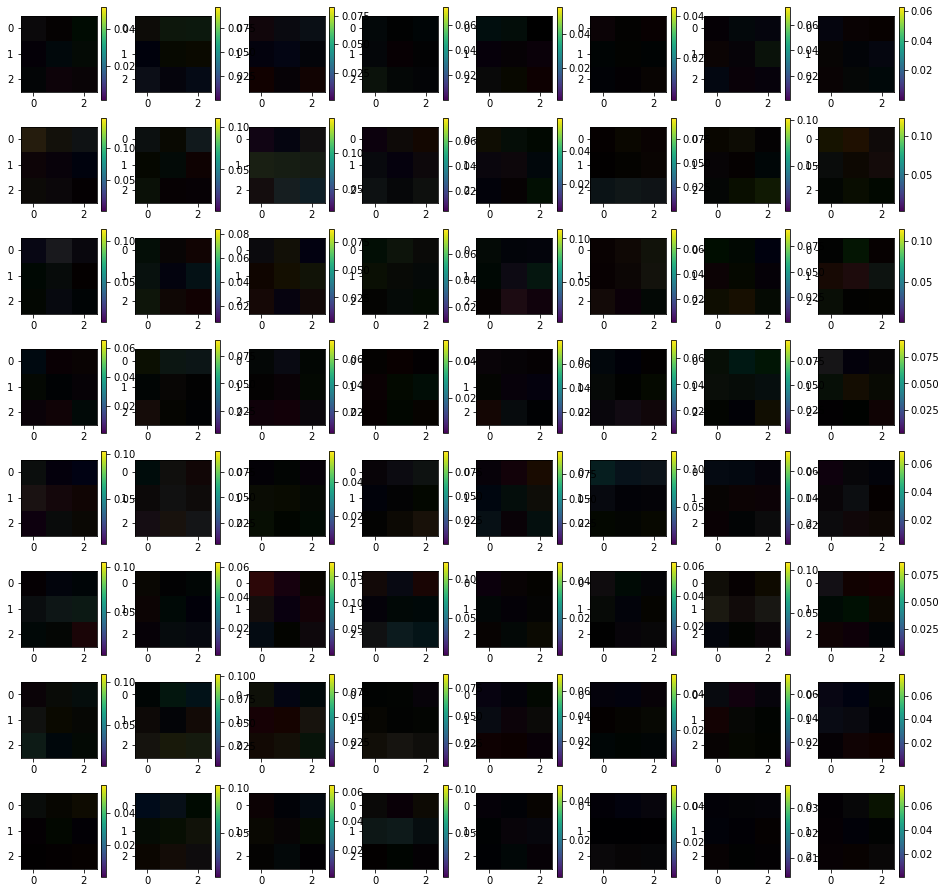

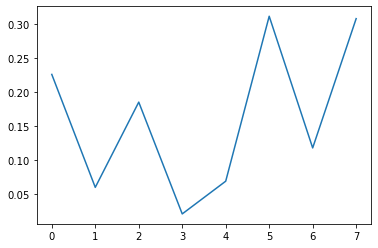

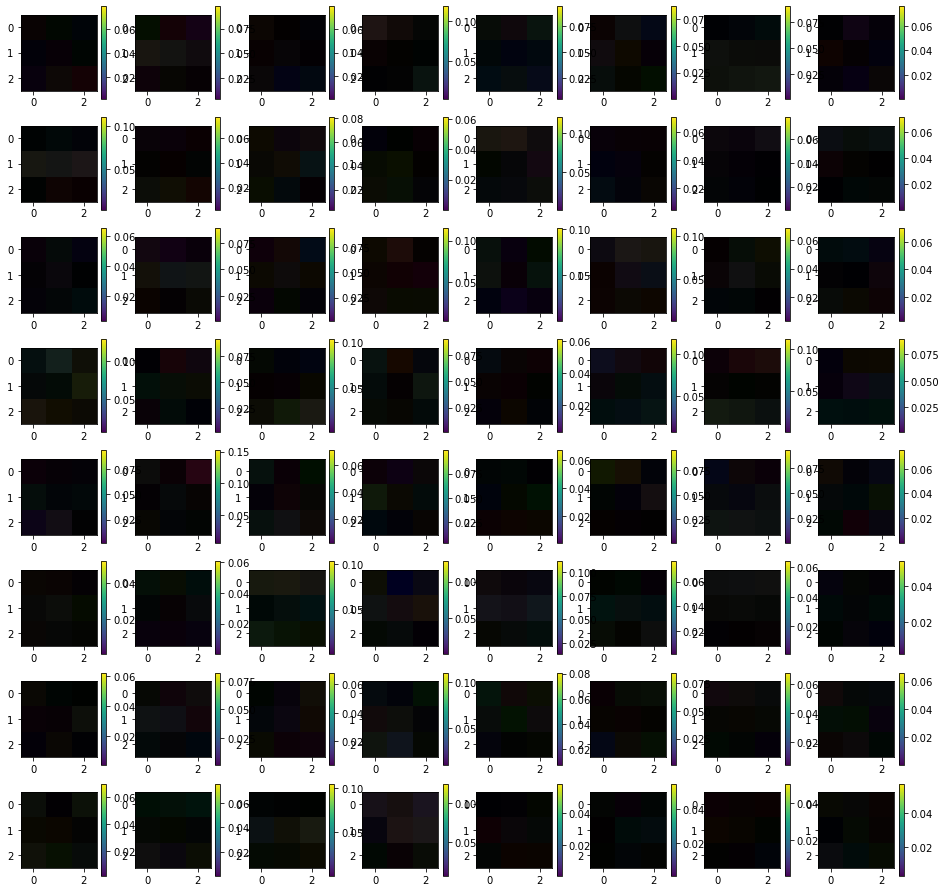

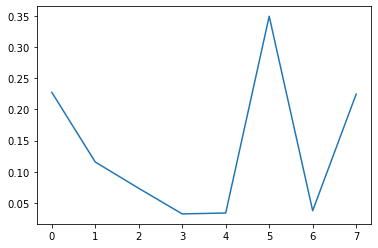

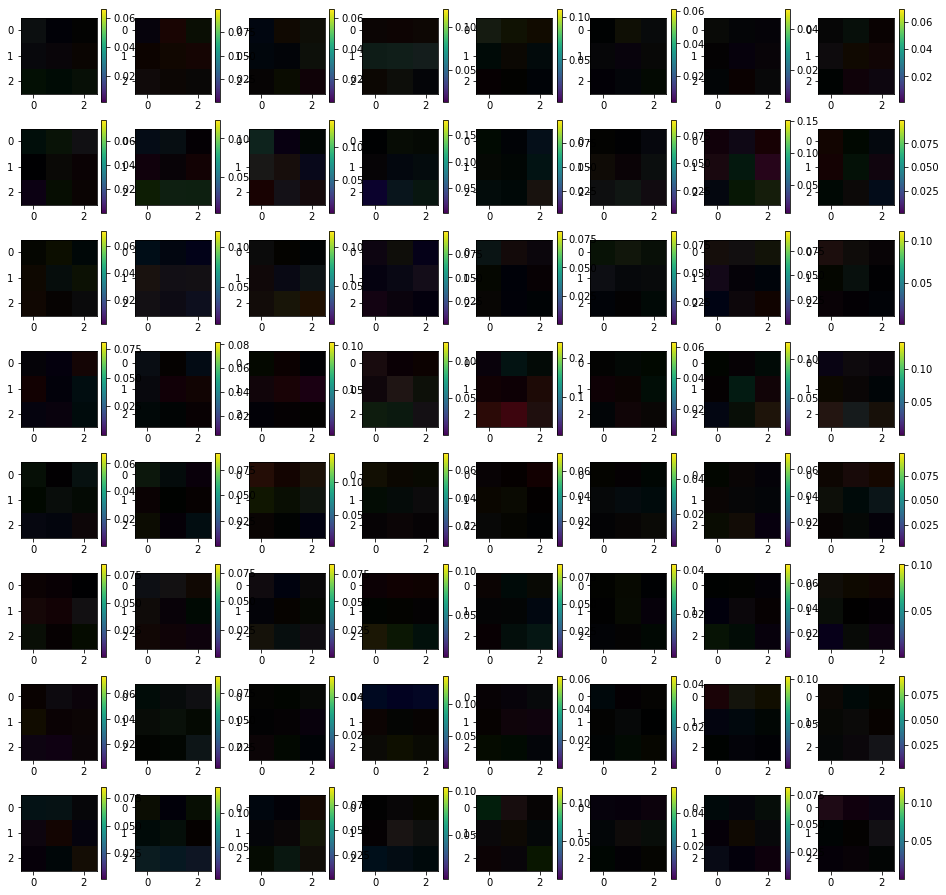

TypeError: 'AxesSubplot' object is not subscriptable

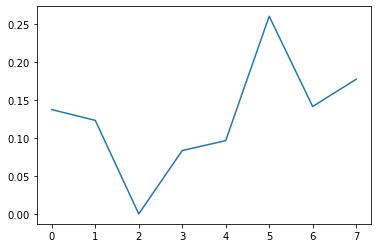

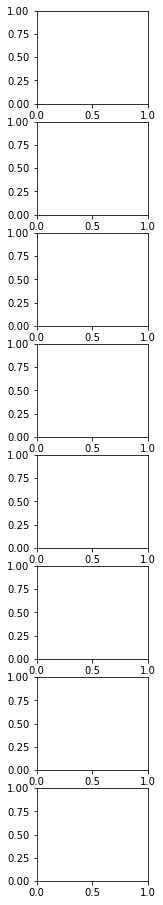

In [3]:
filename_a = r'/home/ep119/repos/fenton_karma_jax/deepexcite/logs/resnet/train/steps/1/0/checkpoints/resnet3720_L0.011343.pickle'
filename_b = r'/home/ep119/repos/fenton_karma_jax/deepexcite/logs/resnet/train/steps/1/0/checkpoints/resnet5425_L0.136448.pickle'
plot_diff_params(filename_a, filename_b)

In [2]:
import jax
import jax.lax
import jax.numpy as jnp
import pickle
import matplotlib.pyplot as plt
from resnet_jax import ResNet
import matplotlib
import warnings
warnings.filterwarnings("ignore")
from jax.tree_util import tree_flatten, tree_unflatten
from operator import sub
from pprint import pprint
from typing import NamedTuple, Callable, Tuple
from jax.experimental import stax
from jax.experimental.stax import Elu, FanInSum, FanOut, GeneralConv, Identity, glorot_normal, normal
import functools
from functools import partial
import os
from resnet_jax import ResNet
import fenton_karma as fk
from dataset import ConcatSequence, imresize
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
class ConvParmas(NamedTuple):
    w: jnp.ndarray
    b: jnp.ndarray

class Module(NamedTuple):
    init: Callable[[jnp.ndarray, Tuple], Tuple[Tuple, jnp.ndarray]]
    apply: Callable[[jnp.ndarray, jnp.ndarray], jnp.ndarray]

def ResidualBlock(out_channels, kernel_size, stride, padding, input_format):
    double_conv = stax.serial(
        GeneralConv(input_format, out_channels, kernel_size, stride, padding),
        Elu,
        GeneralConv(input_format, out_channels, kernel_size, stride, padding),
    )
    return Module(
        *stax.serial(FanOut(2), stax.parallel(double_conv, Identity), FanInSum)
    )

def ResNetUnpacked(hidden_channels, out_channels, kernel_size, strides, padding, depth, input_format):
    return [
        GeneralConv(input_format, hidden_channels, kernel_size, strides, padding),
        *[ResidualBlock(hidden_channels, kernel_size, strides, padding, input_format) for _ in range(depth)],
        GeneralConv(input_format, out_channels, kernel_size, strides, padding)
    ]

def load_params(path, flatten=True):
    with open(path, "rb") as f:
        params = pickle.load(f)
    if flatten:
        params, indices = tree_flatten(params)
        params = [ConvParmas(params[i], params[i + 1]) for i in range(0, len(params), 2)]
        pprint([(x[0].shape, x[1].shape) for x in params])
    return params

def get_hparams(params):
    hidden_channels = params[0].w.shape[-1]
    out_channels = 1
    kernel_size = params[0].w.shape[1:-2]
    strides = (1, 1, 1)
    padding = "SAME"
    depth = len(params) - 2
    input_format = ("NCDWH", "IDWHO", "NCDWH")
    hparams = hidden_channels, out_channels, kernel_size, strides, padding, depth, input_format
    return hparams


def normalise(x):
    return (x - x.min()) / (x.max() - x.min()) 


def plot_activation(unbatched_activation):
    x = normalise(unbatched_activation)
    for i, ax in enumerate(x):
        print(x.shape)
        fig, axes = fk.plot.plot_state(fk.model.State(*x[i]), vmin=None, vmax=None, figsize=(10, 3))
        plt.show()
    return fig, axes
    

def conv(params, inputs):
    W = params.w
    b = params.b
    strides = (1, 1, 1)
    padding = "SAME"
    one = (1, 1, 1)
    return jax.lax.conv_general_dilated(inputs, W, strides, padding, one, one, dimension_numbers=("NCDWH", "IDWHO", "NCDWH")) + b

# def residual_block(params, input):

In [ ]:
filepath_a = r'/home/ep119/repos/fenton_karma_jax/deepexcite/logs/resnet/train/steps/1/0/checkpoints/resnet3720_L0.011343.pickle'
filepath_a = r'/home/ep119/repos/fenton_karma_jax/deepexcite/logs/resnet/train/steps/1/0/checkpoints/resnet5425_L0.136448.pickle'
params_a = load_params(filepath_a)
hparams_a = get_hparams(params_a)

layers_a = ResNetUnpacked(*hparams_a)

data = ConcatSequence("/media/ep119/DATADRIVE3/epignatelli/deepexcite/train_dev_set/", 2, 1, 5, "^spiral.*_PARAMS5.hdf5", partial(imresize, size=(128, 128), method="bilinear"), False)

batch = data[100][None, ...]
x = batch[:, :2]
y_hat = x
fig, ax = plot_activation(y_hat[0])
for param, layer in zip(params_a, layers_a):
    apply_fn = layer[1]
    y_hat = conv(param, y_hat)
    print(y_hat.shape)
    fig, ax = plot_activation(y_hat[0])

[((2, 3, 3, 3, 8), (1, 8, 1, 1, 1)),
 ((8, 3, 3, 3, 8), (1, 8, 1, 1, 1)),
 ((8, 3, 3, 3, 8), (1, 8, 1, 1, 1)),
 ((8, 3, 3, 3, 8), (1, 8, 1, 1, 1)),
 ((8, 3, 3, 3, 8), (1, 8, 1, 1, 1)),
 ((8, 3, 3, 3, 8), (1, 8, 1, 1, 1)),
 ((8, 3, 3, 3, 8), (1, 8, 1, 1, 1)),
 ((8, 3, 3, 3, 8), (1, 8, 1, 1, 1)),
 ((8, 3, 3, 3, 8), (1, 8, 1, 1, 1)),
 ((8, 3, 3, 3, 8), (1, 8, 1, 1, 1)),
 ((8, 3, 3, 3, 8), (1, 8, 1, 1, 1)),
 ((8, 3, 3, 3, 1), (1, 1, 1, 1, 1))]


In [2]:
import numpy as onp

In [ ]:
A = np.zeros((2, 2))
x = 